In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tqdm

# Konstrukcja Query
Query zostanie utworzone dla obszaru miasta Krakowa na podstawie jego współrzędnych zawartych w pliku: https://stm.krakow.pl/wp-content/uploads/2020/02/163572_0.pdf


Korzystając ze strony https://overpass-api.de/query_form.html zostanie pobrany plik o nazwie interpreter.json zawierający odpowiedź

In [2]:
# 19°47’35”E – 20°13’02”E  49°58’04”N – 50°07’32”N
# N -> 50°07’32”N -> 50.1255556 Północna granica
# S -> 49°58’04”N -> 49.9677778 Południowa granica
# W -> 19°47’35”E -> 19.7930556 Zachodnia granica
# E -> 20°13’02”E -> 20.2172222 Wschodnia granica
N = 50.1255556
S = 49.9677778
W = 19.7930556
E = 20.2172222

swne = f"{S},{W},{N},{E}"

query_str = f"""[out:json];node({swne});out;"""

print(query_str)

[out:json];node(49.9677778,19.7930556,50.1255556,20.2172222);out;


# Przetworzenie danych node

In [3]:
# Wczytanie danych z pliku JSON
with open('interpreter_node.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Utworzenie pustych list na wartości id, lat, lon i tag
ids = []
lats = []
lons = []
tags = []

# Przetworzenie danych
for element in data['elements']:
    if 'tags' in element:
        tags.append(element['tags'])
        ids.append(element['id'])
        lats.append(element['lat'])
        lons.append(element['lon'])


# Utworzenie DataFrame'u
node_df = pd.DataFrame({'id': ids, 'lat': lats, 'lon': lons, 'tags': tags})

display(node_df.shape)
node_df.head()


(226485, 4)

,id,lat,lon,tags
0,26860287,50.015517,19.924529,"{'caravans': 'yes', 'email': 'nolcegi@krakowia..."
1,29782993,50.079279,20.027980,"{'bicycle': 'yes', 'check_date:crossing': '202..."
2,29782996,50.079861,20.027947,"{'highway': 'traffic_signals', 'traffic_signal..."
3,29783000,50.084884,20.020373,"{'bus': 'yes', 'name': 'DH Wanda 04', 'public_..."
4,30371892,50.036445,19.825258,"{'bus': 'yes', 'direction': 'backward', 'name'..."


In [4]:
# Wybranie sklepów Żabka
node_df['tags'] = node_df['tags'].astype(str)
zabki_df = node_df[node_df['tags'].str.contains('żabka', case=False)]
zabki_df.reset_index(drop=True, inplace=True)

display(zabki_df.shape)
zabki_df.head()

(391, 4)

,id,lat,lon,tags
0,488395425,50.016238,19.909274,"{'addr:city': 'Kraków', 'addr:housenumber': '6..."
1,490986192,50.065220,19.938758,"{'brand': 'Żabka', 'brand:wikidata': 'Q2589061..."
2,968080349,50.074679,20.047789,"{'addr:city': 'Kraków', 'addr:housenumber': '4..."
3,974197831,50.071429,19.914977,"{'brand': 'Żabka', 'brand:wikidata': 'Q2589061..."
4,1066621887,50.120212,19.967438,"{'brand': 'Żabka', 'brand:wikidata': 'Q2589061..."


In [5]:
# Utworzenie dataframe'u Geopandas
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(zabki_df['lon'], zabki_df['lat'])]
zabki_gdf = gpd.GeoDataFrame(zabki_df, geometry=geometry)
zabki_gdf.crs = {'init': 'epsg:4326'}
zabki_gdf.head()

c:\Users\bugaj\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,id,lat,lon,tags,geometry
0,488395425,50.016238,19.909274,"{'addr:city': 'Kraków', 'addr:housenumber': '6...",POINT (19.90927 50.01624)
1,490986192,50.065220,19.938758,"{'brand': 'Żabka', 'brand:wikidata': 'Q2589061...",POINT (19.93876 50.06522)
2,968080349,50.074679,20.047789,"{'addr:city': 'Kraków', 'addr:housenumber': '4...",POINT (20.04779 50.07468)
3,974197831,50.071429,19.914977,"{'brand': 'Żabka', 'brand:wikidata': 'Q2589061...",POINT (19.91498 50.07143)
4,1066621887,50.120212,19.967438,"{'brand': 'Żabka', 'brand:wikidata': 'Q2589061...",POINT (19.96744 50.12021)


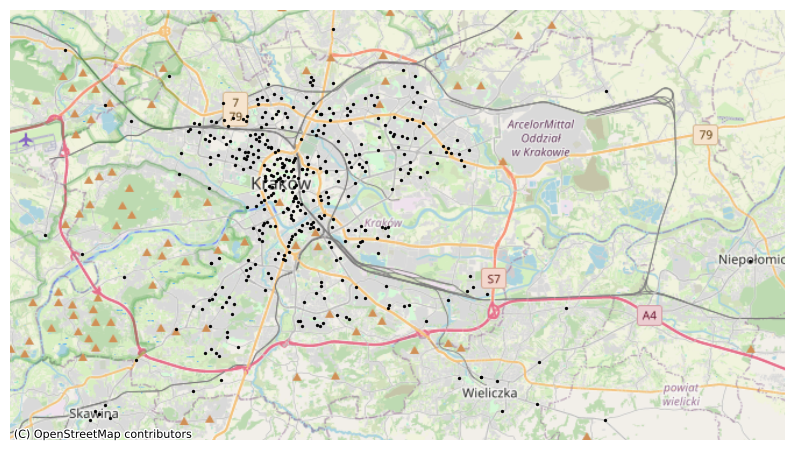

In [6]:
# Zobaczmy sklepy Żabka na mapie Krakowa
import contextily as ctx

fig, ax = plt.subplots(figsize=(10, 10))
zabki_gdf.to_crs(epsg=3857).plot(ax=ax, color='black', alpha=0.9, markersize=2)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')
plt.show()

In [7]:
# Interaktywna mapa z sklepami Żabka
import folium
from folium.plugins import MarkerCluster

# 19°56′E 50°04′N
# E = 19 + 56/60 = 19.9333
# N = 50 + 4/60 = 50.0667
m = folium.Map(location=[50.0667, 19.9333], zoom_start=12)
marker_cluster = MarkerCluster().add_to(m)

for i, row in zabki_gdf.iterrows():
    folium.Marker(location=[row['lat'], row['lon']], popup='Żabka ID:' + '<br>' +str(row['id'])).add_to(marker_cluster)
m.save('zabki.html')

import webbrowser
webbrowser.open('zabki.html')

True

In [8]:
# Zapisanie sklepów Żabka do pliku GeoJSON
zabki_gdf.to_file('zabki.geojson', driver='GeoJSON')


# DANE O ULICACH

Dane o ulicach w krakowie pobierzemy z biliboteki osmnx

In [9]:
import osmnx as ox

G = ox.graph_from_place('Kraków, Poland', network_type='drive')
# Utworzenie GeoDataFrame z ulicami 
streets_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)

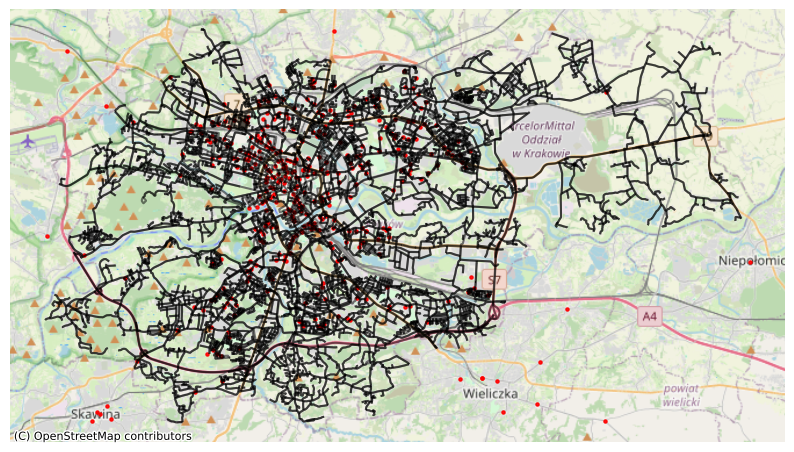

In [10]:
# Mapa ulic i sklepów Żabka
fig, ax = plt.subplots(figsize=(10, 10))
streets_gdf.to_crs(epsg=3857).plot(ax=ax, color='black', alpha=0.5, markersize=2)
zabki_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.9, markersize=5)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')
plt.show()

(2201439.468925791, 2252475.9555697157, 6440043.130753223, 6468528.844798662)

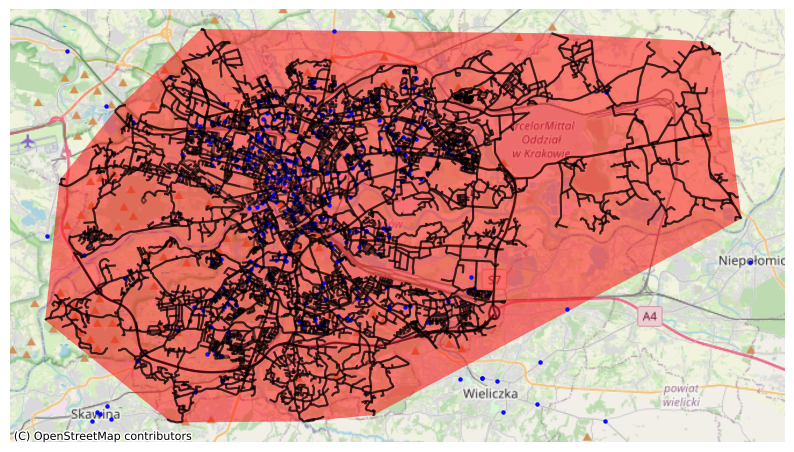

In [11]:
#wybierzmy żabki w obrębie poligonu ograniczającego Kraków na podstawie ulic
import shapely
from shapely.geometry import Polygon

convex_hull = streets_gdf.unary_union.convex_hull

convex_hull_gdf = gpd.GeoDataFrame(geometry=[convex_hull], crs=streets_gdf.crs)

fig, ax = plt.subplots(figsize=(10, 10))
streets_gdf.to_crs(epsg=3857).plot(ax=ax, color='black', alpha=0.5, markersize=2)
convex_hull_gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=0.5)
zabki_gdf.to_crs(epsg=3857).plot(ax=ax, color='blue', alpha=0.9, markersize=5)


ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')

(2201466.728842696, 2251903.4973147013, 6440043.130753223, 6468528.844798662)

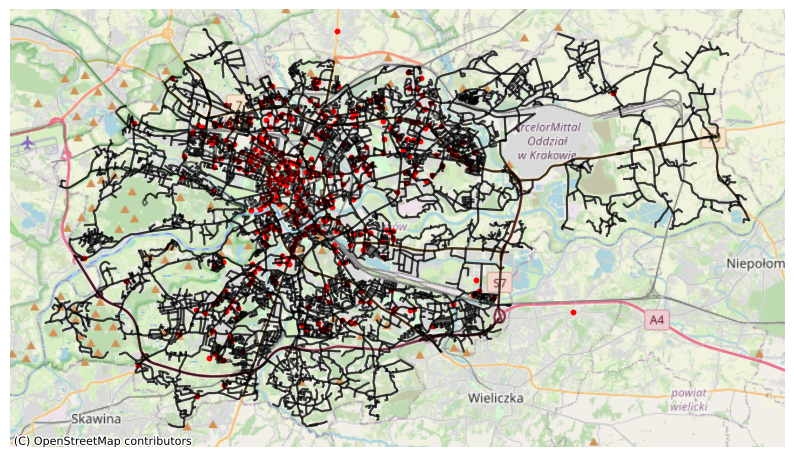

In [12]:
#wybierz żabki w obrębie poligonu
zabki_in_krakow = zabki_gdf[zabki_gdf.within(convex_hull)]
zabki_in_krakow.reset_index(drop=True, inplace=True)

#plot żabki in krakow
fig, ax = plt.subplots(figsize=(10, 10))
streets_gdf.to_crs(epsg=3857).plot(ax=ax, color='black', alpha=0.5, markersize=2)
zabki_in_krakow.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=1, markersize=10)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.axis('off')


Widać tutaj 2 Żabki (Węgrzce i Węgrzce Wielkie), które nie są w Krakowie. 


Zostaną usunięte one po obliczeniu dystansów między żabkami a drogami.

In [13]:
streets_gdf.head()

osmid  oneway  \
u        v          key                                                         
13822575 286069616  0                                        25042019    True   
         32063262   0                                       148469683   False   
         1233263244 0    [200751713, 553072297, 372399967, 997754503]   False   
13822576 13822694   0                                         2954554   False   
         282189298  0                          [553072298, 997754506]   False   

                          lanes  ref                  name      highway  \
u        v          key                                                   
13822575 286069616  0         2  776          Kocmyrzowska    secondary   
         32063262   0         2  NaN       Obrońców Krzyża     tertiary   
         1233263244 0    [3, 2]  NaN       Obrońców Krzyża     tertiary   
13822576 13822694   0       NaN  NaN  Ignacego Mościckiego  residential   
         282189298  0         2  NaN       Obrońców Krzyża     tertiary   

                        maxspeed       reversed   length  \
u        v          key                                    
13822575 286069616  0         50          False  528.224   
         32063262   0         50           True   22.204   
         1233263244 0         50  [False, True]  114.082   
13822576 13822694   0         40          False  115.718   
         282189298  0         50           True   32.238   

                                                                  geometry  \
u        v          key                                                      
13822575 286069616  0    LINESTRING (20.03257 50.08205, 20.03277 50.082...   
         32063262   0    LINESTRING (20.03257 50.08205, 20.03249 50.082...   
         1233263244 0    LINESTRING (20.03257 50.08205, 20.03270 50.081...   
13822576 13822694   0    LINESTRING (20.03435 50.08069, 20.03451 50.080...   
         282189298  0    LINESTRING (20.03435 50.08069, 20.03413 50.080...   

                        tunnel junction width bridge access service est_width  
u        v          key                                                        
13822575 286069616  0      NaN      NaN   NaN    NaN    NaN     NaN       NaN  
         32063262   0      NaN      NaN   NaN    NaN    NaN     NaN       NaN  
         1233263244 0      NaN      NaN   NaN    NaN    NaN     NaN       NaN  
13822576 13822694   0      NaN      NaN   NaN    NaN    NaN     NaN       NaN  
         282189298  0      NaN      NaN   NaN    NaN    NaN     NaN       NaN

In [14]:
#simplify streets_gdf to get only geometry and length
streets_gdf.reset_index(inplace=True)
streets_gdf = streets_gdf[['geometry', 'length']]
streets_gdf.head()

,geometry,length
0,"LINESTRING (20.03257 50.08205, 20.03277 50.082...",528.224
1,"LINESTRING (20.03257 50.08205, 20.03249 50.082...",22.204
2,"LINESTRING (20.03257 50.08205, 20.03270 50.081...",114.082
3,"LINESTRING (20.03435 50.08069, 20.03451 50.080...",115.718
4,"LINESTRING (20.03435 50.08069, 20.03413 50.080...",32.238


In [ ]:
all_street_points = []
for i, row in streets_gdf.iterrows():
    if row['geometry'].geom_type == 'LineString':
        for point in list(row['geometry'].coords):
            all_street_points.append(Point(point))
    elif row['geometry'].geom_type == 'MultiLineString':
        for linestring in row['geometry']:
            for point in list(linestring.coords):
                all_street_points.append(Point(point))
                

In [19]:
import geopandas as gpd
from shapely.ops import nearest_points
from geopy.distance import geodesic


distances_data = []

for i, row in tqdm.tqdm(zabki_in_krakow.iterrows(), total=zabki_in_krakow.shape[0]):
    point = row['geometry']
    #find nearest street point to the shop
    nearest_point = nearest_points(point, shapely.geometry.MultiPoint(all_street_points))[1]
    #calculate distance between shop and nearest street point
    distance = geodesic((point.y, point.x), (nearest_point.y, nearest_point.x)).meters
    distances_data.append({'id': row['id'], 'distance': distance, 'geometry' : nearest_point})


distances_df = pd.DataFrame(distances_data)
#Usunięcie 2 największych wartości
distances_df = distances_df[distances_df['distance'] < distances_df['distance'].nlargest(2).min()]
distances_df.reset_index(drop=True, inplace=True)

distances_df.head()

100%|██████████| 374/374 [09:32<00:00,  1.53s/it]


,id,distance,geometry
0,488395425,17.085090,POINT (19.9090584 50.0161726)
1,490986192,12.124306,POINT (19.9387072 50.0653243)
2,968080349,23.175650,POINT (20.0479064 50.074485)
3,974197831,30.098557,POINT (19.914764 50.0716622)
4,1238620983,103.203805,POINT (19.9269777 50.0864695)


In [21]:
#save to geojson
distances_gdf = gpd.GeoDataFrame(distances_df, geometry='geometry')
distances_gdf.to_file('nearest.geojson', driver='GeoJSON')


In [ ]:
distances_gdf = gpd.read_file('nearest.geojson')
distances_gdf.head()

,żabka_id,distance,geometry
0,488395425,16.175409,POINT (19.90921 50.01610)
1,490986192,8.742188,POINT (19.93879 50.06530)
2,968080349,21.343203,POINT (20.04774 50.07487)
3,974197831,30.522374,POINT (19.91494 50.07116)
4,1238620983,103.203805,POINT (19.92698 50.08647)


In [ ]:
# Interaktywna mapa z ulicami, sklepami Żabka i najbliższymi punktami

zabki_gdf = zabki_gdf[zabki_gdf['id'].isin(distances_df['żabka_id'])]
zabki_gdf.reset_index(drop=True, inplace=True)
zabki_gdf.to_file('zabki_krakow.geojson', driver='GeoJSON')

m = folium.Map(location=[50.0667, 19.9333], zoom_start=12)
marker_cluster = MarkerCluster().add_to(m)

for i, row in zabki_gdf.iterrows():
    folium.Marker(location=[row['lat'], row['lon']], popup='Żabka ID:' + '<br>' +str(row['id'])).add_to(marker_cluster)

for i, row in streets_gdf.iterrows():
    coords = list(row['geometry'].coords)
    locations = [(y, x) for x, y in coords]
    folium.PolyLine(locations=locations, color='black').add_to(m)

for i, row in distances_gdf.iterrows():
    idx = row['żabka_id']
    nearest_point = row['nearest_point']
    folium.PolyLine(locations=[(zabki_gdf[zabki_gdf['id'] == idx]['lat'].values[0], zabki_gdf[zabki_gdf['id'] == idx]['lon'].values[0]),
                                (nearest_point.y, nearest_point.x)], color='red').add_to(m)
    
    folium.Marker(location=[nearest_point.y, nearest_point.x], popup='Nearest point to Żabka ID:' + '<br>' +str(row['żabka_id']) + '<br>' + 'Distance: ' + str(round(row['distance'], 2)) + ' m').add_to(m)



m.save('zabki_and_streets.html')
webbrowser.open('zabki_and_streets.html')

True